In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = T.Compose([T.Resize(size=(224, 224)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
full_dataset = torchvision.datasets.Caltech256(
    root='./data',
    download=True,
    transform=transform
)

train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 33.3MB/s]


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=256):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = AlexNet(num_class=256)
model.to(device)
print(f'using {device} device')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

NUM_EPOCHS = 25

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_train_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f'--- Epoch {epoch + 1} Summary ---')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.2f} %')
    print('--------------------------\n')

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy)


using cuda device
Epoch [1/25], Step [100/704], Loss: 6.8500
Epoch [1/25], Step [200/704], Loss: 6.6740
Epoch [1/25], Step [300/704], Loss: 3.1758
Epoch [1/25], Step [400/704], Loss: 2.4038
Epoch [1/25], Step [500/704], Loss: 2.3752
Epoch [1/25], Step [600/704], Loss: 2.3512
Epoch [1/25], Step [700/704], Loss: 2.3386
--- Epoch 1 Summary ---
Validation Loss: 2.2852
Validation Accuracy: 14.18 %
--------------------------

Epoch [2/25], Step [100/704], Loss: 2.3120
Epoch [2/25], Step [200/704], Loss: 2.2795
Epoch [2/25], Step [300/704], Loss: 2.2720
Epoch [2/25], Step [400/704], Loss: 2.2467
Epoch [2/25], Step [500/704], Loss: 2.1823
Epoch [2/25], Step [600/704], Loss: 2.1026
Epoch [2/25], Step [700/704], Loss: 2.0534
--- Epoch 2 Summary ---
Validation Loss: 2.0043
Validation Accuracy: 27.74 %
--------------------------

Epoch [3/25], Step [100/704], Loss: 2.0172
Epoch [3/25], Step [200/704], Loss: 2.0176
Epoch [3/25], Step [300/704], Loss: 1.9538
Epoch [3/25], Step [400/704], Loss: 1.921

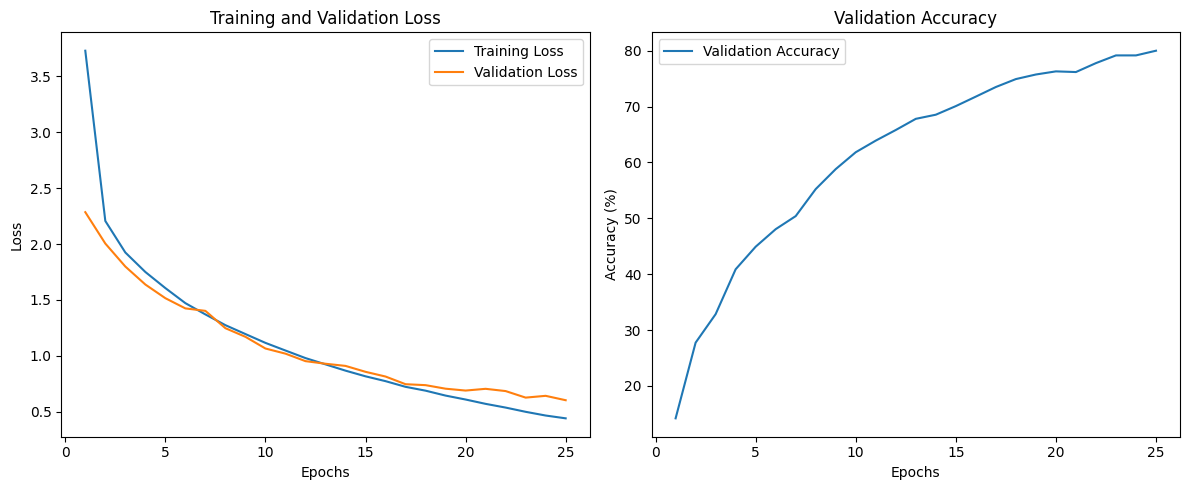

In [ ]:
epochs_range = range(1, NUM_EPOCHS + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()